# Uncertainty Calibration

Posterior uncertainty of the probabilistic linear solver can be calibrated by building a regression model for the Rayleigh coefficient $$\ln R(A, s) = \ln \frac{s^\top A s}{s^\top s}$$ at convergence after $k \ll n$ iterations.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [9.5, 6]
#plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsfonts}', 
                                       r'\usepackage{amsmath}',
                                       r'\usepackage{bm}']

plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "pgf.preamble": [
        # LaTeX preamble declarations
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        # macros defined here will be available in plots
        r"\newcommand{\vect}[1]{#1}",
    ],
})

## Test Problem

In [2]:
import numpy as np
import scipy.linalg
import GPy

# Gram matrix test problem
np.random.seed(0)

# Toy data
n = 1000
x_min, x_max = (-10., 10.)
X = np.random.uniform(x_min, x_max, (n,1))
Y = np.cos(X ** 2) + np.random.normal(size=(n, 1)) * 0.05

# Kernel
kernel = GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=1)

# Kernel Gram Matrix
K = kernel.K(X=X, X2=X)
sigma = 10 ** -6 * n
A = K + sigma * np.eye(K.shape[0])

# Sample solution
x_true = np.random.normal(size=(n, ))

# Right hand side
b = A @ x_true

# Condition number
print(np.linalg.cond(A))

118035.53492009305


## Solution via Probabilistic Linear Solver

In [3]:
from probnum.linalg.linops import Identity, SymmetricKronecker
from probnum.prob import RandomVariable, Normal
from probnum.linalg import problinsolve

# Callback function to get matrix projections
S = []  # search directions
Y = []  # observations
alpha = []  # step lengths

def callback_fun(xk, Ak, Ainvk, sk, yk, alphak, resid):
    S.append(sk)
    Y.append(yk)
    alpha.append(np.squeeze(alphak))

# Solve with probabilistic linear solver
xhat, Ahat, Ainvhat, info_pls = problinsolve(A=A, b=b, callback=callback_fun, calibration="gpkern", maxiter=n)
print(info_pls)

{'iter': 91, 'maxiter': 1000, 'resid_l2norm': 0.0001990749905536614, 'trace_sol_cov': 0.3344653784073755, 'conv_crit': 'resid_rtol', 'rel_cond': None}


In [4]:
# Transform callback quantities
S = np.squeeze(np.array(S)).T
Y = np.squeeze(np.array(Y)).T

# Compute eigenvalues
eigs = np.real_if_close(np.sort(np.linalg.eigvals(A))[::-1])
print(eigs[0:info_pls["iter"]])

# Condition number of problem
np.linalg.cond(A)

[1.18035535e+02 1.06161083e+02 1.02746509e+02 9.55186126e+01
 8.48673811e+01 7.24508641e+01 6.05644183e+01 5.39154031e+01
 4.63226301e+01 3.83600142e+01 3.24950665e+01 2.72277176e+01
 2.21625982e+01 1.91797237e+01 1.58976810e+01 1.37026337e+01
 1.14979871e+01 1.01836885e+01 8.11189917e+00 7.26529828e+00
 5.96866547e+00 5.20630383e+00 4.59033268e+00 3.90466174e+00
 3.48295021e+00 2.85595281e+00 2.60148352e+00 2.33091683e+00
 2.04998592e+00 1.79406896e+00 1.63439711e+00 1.42887507e+00
 1.34761238e+00 1.12160000e+00 1.03572155e+00 9.21668009e-01
 8.22784198e-01 7.91258257e-01 6.68856942e-01 6.25756615e-01
 5.57377165e-01 5.09811828e-01 4.74810238e-01 4.37078606e-01
 4.04467097e-01 3.62152266e-01 3.38521635e-01 3.15898939e-01
 2.93472126e-01 2.74350384e-01 2.47912189e-01 2.22544961e-01
 2.06112572e-01 1.95733762e-01 1.79856813e-01 1.63124061e-01
 1.56271651e-01 1.46341603e-01 1.38514338e-01 1.33943034e-01
 1.20946907e-01 1.13530687e-01 1.07979175e-01 1.02187815e-01
 8.79157119e-02 8.514586

118035.53492009305

## Rayleigh Coefficients and Regression Model

In [5]:
# Compute matrix projections
a_proj = np.einsum('nk,nk->k', S, Y) / np.einsum('nk,nk->k', S, S)
iters = np.arange(0, len(a_proj))

# GP mean function via Weyl's result on spectra of Gram matrices: ln(sigma(n)) ~= theta_0 - theta_1 ln(n)
lnmap = GPy.core.Mapping(1, 1)
lnmap.f = lambda n: np.log(n + 10**-16)
lnmap.update_gradients = lambda a, b: None
mf = GPy.mappings.Additive(GPy.mappings.Constant(1, 1, value=0),
                           GPy.mappings.Compound(lnmap, GPy.mappings.Linear(1, 1)))

# Log-Rayleigh quotient modelled with a Gaussian process
k = GPy.kern.RBF(input_dim=1, lengthscale=1, variance=1)

In [6]:
print(mf)

  mapping.          |          value  |  constraints  |  priors
  constmap.C        |            0.0  |               |        
  mapping.linmap.A  |  [-0.83777626]  |               |        


In [7]:
m = GPy.models.GPRegression(iters[:, None] + 1, np.log(a_proj)[:, None],# - beta0, 
                            kernel=k, mean_function=mf)
m.optimize(messages=1, ipython_notebook=True)

In [8]:
# Compute scale
logR_pred = m.predict(np.arange(info_pls["iter"] + 1, n + 1)[:, None])[0]
phi = np.exp(np.mean(logR_pred))
psi = np.exp(np.mean(-logR_pred))
print(f"Calibration scales phi = {phi} and psi = {psi}.")

Calibration scales phi = 0.002110968658241169 and psi = 473.71617579257986.


## Predict and Plot

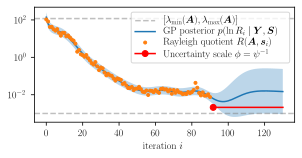

In [27]:
# Figure and setup
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 2), 
                         sharex=True,
                         squeeze=False)
pred_iters = np.arange(1, info_pls["iter"] + 41)

# Predict log Rayleigh quotient
GP_pred = m.predict(pred_iters[:, None])
a_pred_GPmean = GP_pred[0].ravel()# + beta0
a_pred_GP2std = 2 * np.sqrt(GP_pred[1].ravel())

# Plot
axes[0, 0].axhline(y=np.max(eigs), color="gray", alpha=0.5, linestyle="--", 
                   label="$[\\lambda_{\\min}(\\bm{A}), \\lambda_{\\max}(\\bm{A})]$")
axes[0, 0].axhline(y=np.min(eigs), color="gray", alpha=0.5, linestyle="--")
axes[0, 0].fill_between(x=pred_iters-1, y1=np.exp(a_pred_GPmean - a_pred_GP2std),
                        y2=np.exp(a_pred_GPmean + a_pred_GP2std), alpha=.3)
axes[0, 0].plot(pred_iters-1, np.exp(a_pred_GPmean), label="GP posterior $p(\\ln R_i \\mid \\bm{Y}, \\bm{S})$")
axes[0, 0].plot(iters, a_proj, ".", label="Rayleigh quotient $R(\\bm{A}, \\bm{s}_{i})$")
axes[0, 0].axhline(y=phi, xmin=iters[-1] / pred_iters[-1], xmax=.955, 
                   label="Uncertainty scale $\\phi=\psi^{-1}$", 
                   color="red", linestyle="-", marker="o", markevery=1.)
axes[0, 0].set_xlabel("iteration $i$")
axes[0, 0].set_yscale("log")

plt.legend(fontsize=10, labelspacing=.1)
plt.tight_layout(pad=0)

# Save to file
fig.savefig("../figures/rayleigh_quotient.pdf", bbox_inches="tight", pad_inches = 0.)

In [10]:
print(mf)

  mapping.          |               value  |  constraints  |  priors
  constmap.C        |  3.1326393355505022  |               |        
  mapping.linmap.A  |       [-1.50652675]  |               |        


## Uncertainty Calibration

We measure the effect of the calibration procedure by computing the ratio between the numerical uncertainty and the true error.

In [23]:
import scipy.sparse.linalg

# Solve with probabilistic linear solver
xhat, Ahat, Ainvhat, info_pls = problinsolve(A=A, b=b, maxiter=n, calibration="gpkern")

In [24]:
print(info_pls)

{'iter': 91, 'maxiter': 1000, 'resid_l2norm': 0.0001990749905536614, 'trace_sol_cov': 0.33443496931005917, 'conv_crit': 'resid_rtol', 'rel_cond': None}


In [25]:
sigma_trace = info_pls["trace_sol_cov"]
print("\sqrt(trace(Sigma)) = " + str(np.sqrt(sigma_trace)))
l2_error = np.linalg.norm(x_true.ravel() - xhat.mean().ravel(), ord=2)
print(f"l2-error = {l2_error}")
print(f"test statistic w = {0.5 * np.log(sigma_trace) - np.log(l2_error)}")

\sqrt(trace(Sigma)) = 0.5783035269735601
l2-error = 0.04591245325460829
test statistic w = 2.5333624710060354
